In [44]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import PIL 

clean data -- create directory to hold images.

In [84]:
#directories
face_csv_filepath = 'data/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [114]:
#load csv
def face_csv_to_df(csv_pathname):
    
    directory = os.getcwd() #returns path to current directory
    try:
        #create dataframe containing image expression label number, usage, and pixels.
        facedata = pd.read_csv(os.path.join(directory, csv_pathname))
        print("Dataframe of CSV successfully created.")
    except:
        print("Issue raised creating dataframe.")
        return 0
    
    facedata = facedata.rename(columns=lambda x: x.strip().lower())
    print(f"initial columns in dataframe: {facedata.columns}")
    
    #create column for emotion label to increase interpretability
    facial_expression = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #dictionary to map label names
    facedata['label_name'] = facedata['emotion'].map(facial_expression)
    print("label_name column added to dataframe.")
    
    #relabel public and private test usage rows to solely test
    for usage_type in ['PrivateTest', 'PublicTest']: 
        facedata.loc[(facedata.usage == usage_type),'usage'] = 'Test'
    print("Usage column updated.")
    
    
    #convert string of pixel data to array reshaped.
    img_shape = (48,48)
    facedata['pixels'] = facedata['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48,48))
    print("pixels column converted to numpy array.")
    

    return facedata

In [115]:
face = face_csv_to_df(face_csv_filepath)

Dataframe of CSV successfully created.
initial columns in dataframe: Index(['emotion', 'usage', 'pixels'], dtype='object')
label_name column added to dataframe.
Usage column updated.
pixels column converted to numpy array.


## Review dataframe created.

In [154]:
distribution_labels = face.groupby('usage')['label_name'].value_counts()

In [181]:
distribution_labels.max()*1.2

8658.0

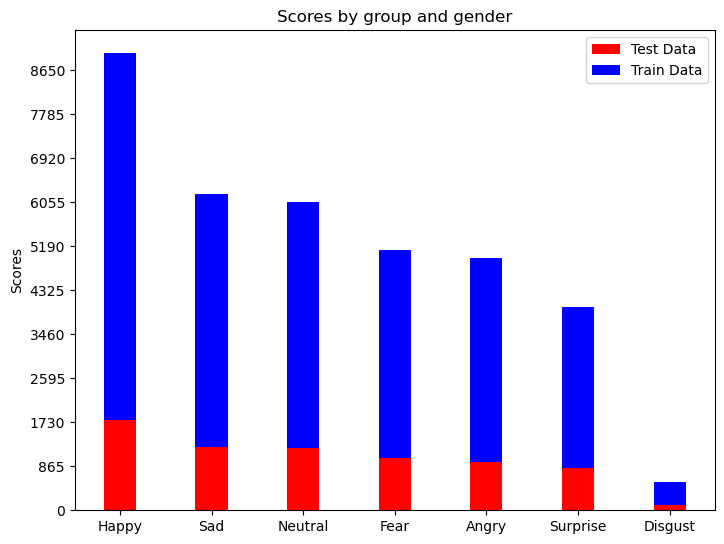

In [183]:
N = distribution_labels.groupby(level='usage').count()[0]

menMeans = distribution_labels.Test.values
womenMeans = distribution_labels.Training.values
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, womenMeans, width, bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, (distribution_labels.Test.keys()))
tick_no = (distribution_labels.max()*1.2)
ax.set_yticks(np.arange(0, tick_no, tick_no//10))
ax.legend(labels=['Test Data', 'Train Data'])
plt.show()

In [139]:
m = face.pixels[0].reshape(48,48,1)

<class 'PIL.Image.Image'>


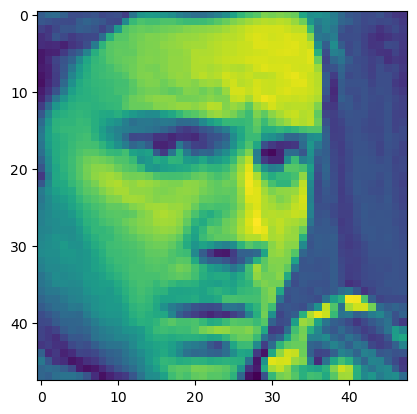

In [140]:
from tensorflow.keras.utils import array_to_img

img_pil = array_to_img(m)
print(type(img_pil))

# show image
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(img_pil)